# Table of Contents
 <p><div class="lev1"><a href="#Boilerplate-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Boilerplate</a></div><div class="lev2"><a href="#Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></div><div class="lev2"><a href="#GetData-Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>GetData Functions</a></div><div class="lev2"><a href="#Get-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Get Data</a></div><div class="lev2"><a href="#Pickle-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Pickle</a></div><div class="lev3"><a href="#Load-Data-From-Pickles-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Load Data From Pickles</a></div><div class="lev2"><a href="#Colormaps-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Colormaps</a></div><div class="lev1"><a href="#Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></div><div class="lev2"><a href="#Categories-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Categories</a></div><div class="lev2"><a href="#Intrade-Lifetime-Analysis-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Intrade Lifetime Analysis</a></div><div class="lev3"><a href="#Active-Markets-Over-Time-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Active Markets Over Time</a></div><div class="lev1"><a href="#Boilerplate-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Boilerplate</a></div><div class="lev2"><a href="#Imports-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Imports</a></div><div class="lev2"><a href="#GetData-Functions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>GetData Functions</a></div><div class="lev2"><a href="#Get-Data-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Get Data</a></div><div class="lev2"><a href="#Pickle-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Pickle</a></div><div class="lev3"><a href="#Load-Data-From-Pickles-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Load Data From Pickles</a></div><div class="lev2"><a href="#Colormaps-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Colormaps</a></div><div class="lev1"><a href="#Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analysis</a></div><div class="lev2"><a href="#Categories-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Categories</a></div><div class="lev2"><a href="#Intrade-Lifetime-Analysis-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Intrade Lifetime Analysis</a></div><div class="lev3"><a href="#Active-Markets-Over-Time-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Active Markets Over Time</a></div>

# Boilerplate

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rpy2.robjects as rob
import seaborn as sns
from datetime import datetime
import os
import pickle
from scipy.special import logit
from tqdm import tqdm
import re
from itertools import islice

INTRADE_PATH = '/home/jai/Intrade-Contracts-NoFinancial/'

## GetData Functions

In [132]:
def read_trade_times(times):
    return [datetime.strptime(t, '%b/%d/%Y %H:%M:%S') for t in times]

def colname_fix(df):
    print 'Fixing column names...'
    columns = map(lambda x: re.sub(r'[\[\/\]]', '', x), df.columns)
    columns = map(lambda x: '_'.join(x.split(' ')), columns)
    df.rename(columns=dict(zip(df.columns, columns)), inplace=True)
    return df

def tradescsv_or_nothing(csv_path, intrade_path=INTRADE_PATH):
    try:
        df = pd.read_csv(csv_path, parse_dates=[5], date_parser=read_trade_times)
        category = csv_path.split(intrade_path)[1].split('/')[0]
        df['category'] = category
        return df
    except ValueError:
        return None
    
def get_trade_paths(intrade_path):
    trades=[]
    for dp, dn, fns in os.walk(intrade_path):
        sumfns = filter(lambda x: x.endswith('trades.csv'), fns)
        trades += map(lambda x: os.path.join(dp, x), sumfns)
    return trades

def hey(msg='hey'):
    def f(x):
        print msg
        return x
    return f

def read_trade_csvs(intrade_path):
    print 'Reading trade csvs...'
    readcsv = lambda csv_path: tradescsv_or_nothing(csv_path, intrade_path)
    return colname_fix(pd.concat(hey('Concatenating dfs...')(map(
                readcsv, 
                tqdm(get_trade_paths(intrade_path))
            ))))

def remove_weird_markets(trades):
    weird_mkts = \
        r'ELECTORALVOTES$|\-OPENING\.WEEKEND$|^LIV-EX100\.|^MEI.MOSES|^TOTAL.SEATS.|^ELEC.COL.VOTES'
    trades = trades[~trades.market_symbol.str.contains(weird_mkts)]
    trades = trades[~trades.market_id.isin((650479, 673548))]
    return trades.copy()

def mgroup(t):
    return t.groupby('market_id')

def mdgroup(t):
    return t.groupby(['market_id', 'days'])

def mhgroup(t):
    return t.groupby(['market_id', 'hours'])

logcache = dict()
def getlog(x):
    if x not in logcache:
        logcache[x] = np.log(x)
    return logcache[x]

def get_trades(path=INTRADE_PATH, trades=None, tradesfname=None):
    if tradesfname is not None:
        print 'loading raw trading data from pickle...',
        trades = pload(tradesfname)
    else:
        trades = trades or read_trade_csvs(path)
    trades = trades[~trades.trade_price.isnull()].copy()
    trades = remove_weird_markets(trades)
    alls = (lambda t=None: slice(None))
    assignments = [
        (alls, 'market_symbol', lambda t: t.market_symbol.astype('category')),
        (alls, 'market_name', lambda t: t.market_name.astype('category')),
        (alls, 'p', lambda t: t.trade_price/100.),
        (alls, 'final_time', lambda t: mgroup(t).datetime_utc.transform('max')),
        (alls, 'final_p', lambda t: t.p * (t.datetime_utc==t.final_time)),
        (alls, 'final_p', lambda t: mgroup(t).p.transform('max')),
        (alls, 'countdown', lambda t: t.datetime_utc - t.final_time),
        (alls, 'hours', lambda t: np.round(t.countdown.dt.total_seconds()/3600., 0)),
        (alls, 'days', lambda t: np.round(t.countdown.dt.total_seconds()/86400., 0)),
        (alls, 'result', lambda t: np.full(t.shape[0], np.nan)),
        (lambda t: t.final_p>=0.95, 'result', lambda t: 1),
        (lambda t: t.final_p<=0.05, 'result', lambda t: 0),
        (alls, 'year', lambda t: t.datetime_utc.dt.year),
        (alls, 'final_year', lambda t: t.final_time.dt.year),
        (alls, 'start_time', lambda t: mgroup(t).datetime_utc.transform('min')),
        (alls, 'duration', lambda t: t.final_time - t.start_time),
        (alls, 'lodds', lambda t: np.log(t.p/(1.0 - t.p))),
        (alls, 'log_loss', lambda t: np.nan),
        (lambda t: t.result==1, 'log_loss', lambda t: t.p.apply(getlog)),
        (lambda t: t.result==0, 'log_loss', lambda t: (1.0-t.p).apply(getlog))
    ]
    print 'Adding columns...'
    for rowf, col, getvals in assignments:
        print col,
        trades.loc[rowf(trades), col] = getvals(trades.loc[rowf(trades), :])
    trades.index = trades.datetime_utc
    print ' * sorting by datetime * ',
    trades.sort_index(inplace=True)
    return trades.copy()

def rs_sum_zero(data, ts='D'):
    """Resample data by sum, fill upsamples with 0"""
    return data.resample(ts, how='sum').fillna(0)

def fill_from_prev(trades, prev_trades):
    times = trades.index
    start = times.min()
    markets = trades.market_id.unique()
    covered_markets = trades[times==start].market_id.unique()
    tofill_markets = [m for m in markets if not m in covered_markets]
    last_entries = prev_trades[prev_trades.market_id.isin(tofill_markets)].groupby('market_id').last()
    last_entries.trade_quantity = 0
    last_entries['market_id'] = last_entries.index
    last_entries.index = pd.Series([start]*last_entries.shape[0])
    for c in ('datetime_utc', 'countdown', 'hours', 'days'):
        last_entries[c] = trades[c].min()
    return pd.concat((trades, last_entries))

def resample_trades(trades, ts='D', prev_trades=None):
    """Resample trades at some time frequency (default: calendar day)
    
    For most columns, take the last value each day and forward fill.
    For trade_quantity, same the sum each day and fill NAs with 0
    Add a "num_trades" column
    """
    if prev_trades is not None:
        trades = fill_from_prev(trades, prev_trades)
    trades = trades.copy()
    trades['num_trades'] = 1
    all_mtrades = []
    tsrules = dict((c, 'last') for c in trades.columns)
    tsrules['trade_quantity'] = 'sum'
    tsrules['num_trades'] = 'sum'
    trades.sort_values('market_id', inplace=True)
    for m in trades.market_id.unique():
        if np.random.random() < 0.02:
            print '.',
        mtrades = trades[trades.market_id==m]
        mquantity = rs_sum_zero(mtrades.trade_quantity)
        mnumtrades = rs_sum_zero(mtrades.num_trades)
        mdtrades = mtrades.resample(ts, how=tsrules, fill_method='ffill')
        mdtrades.trade_quantity = mquantity
        mdtrades.num_trades = mnumtrades
        all_mtrades.append(mdtrades)
    dtrades = pd.concat(all_mtrades)
    trades.sort_index(inplace=True)
    return dtrades

def get_market_info(trades):
    mt = mgroup(trades)
    market_info = mt.last()[[
        'market_symbol', 
        'market_name', 
        'category', 
        'final_time', 
        'start_time', 
        'final_p', 
        'duration',
        'final_year',
        'result'
    ]]
    market_info['total_volume'] = mt.trade_quantity.sum()
    market_info['num_trades'] = mt.market_id.count()
    return market_info

def get_trade_days(trades, market_info):
    tradedays = resample_trades(
        trades[resolved_filter].loc[
            :, 
            ['market_id', 'p', 'trade_quantity']])
    tradedays = tradedays.merge(market_info, left_on='market_id', right_index=True)
    tradedays = tradedays[~tradedays.result.isnull()]
    tradedays['log_loss'] = np.nan
    tradedays.loc[tradedays.result==1, 'log_loss'] = np.log(tradedays.loc[tradedays.result==1, 'p'])
    tradedays.loc[tradedays.result==0, 'log_loss'] = np.log(1. - tradedays.loc[tradedays.result==0, 'p'])
    tradedays['date'] = tradedays.index
    return tradedays

## Get Data

In [145]:
trades = get_trades(tradesfname='raw_trades')

loading raw trading data from pickle... Adding columns...
market_symbol market_name p final_time final_p final_p countdown hours days result result result year final_year start_time duration lodds log_loss log_loss log_loss  * sorting by datetime * 


In [153]:
market_info = get_market_info(trades)

In [ ]:
tradedays = get_trade_days(trades, market_info)

## Pickle

In [3]:
def ppath(name, base=INTRADE_PATH):
    return os.path.join(base, name + '.pickle')

def pdump(thing, name):
    with open(ppath(name), 'w+') as f:
        pickle.dump(thing, f, pickle.HIGHEST_PROTOCOL)

def pload(name):
    with open(ppath(name)) as f:
        x = pickle.load(f)
    return x

In [156]:
pdump(market_info, 'market_info')

In [157]:
pdump(raw_trades, 'raw_trades')

In [158]:
pdump(trades, 'trades')

In [160]:
pdump(tradedays, 'tradedays')

### Load Data From Pickles

In [7]:
trades = pload('trades')
market_info = pload('market_info')
tradedays = pload('tradedays')

## Colormaps

In [4]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    np.logspace
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap
cmap = sns.diverging_palette(h_neg=15, h_pos=255, s=99, l=35, sep=1, n=15, as_cmap=True)
scmap = shiftedColorMap(cmap, start=0.0, midpoint=0.33, stop=1.0)

# Analysis

## Categories

<IPython.core.display.Javascript object>


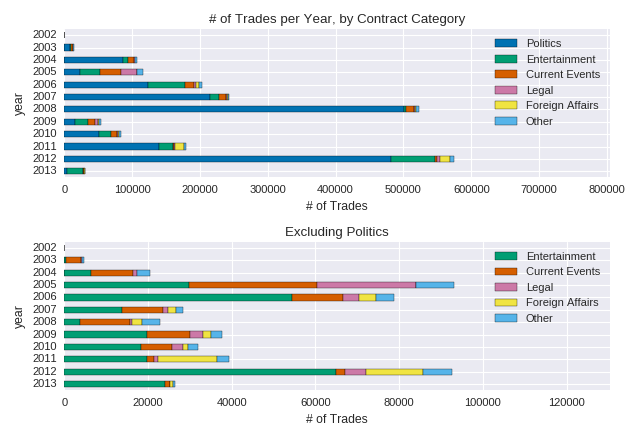

In [164]:
%matplotlib notebook

sns.set()

ncats = 5

color = sns.color_palette('colorblind', n_colors=(ncats+1))

f, (ax1, ax2) = plt.subplots(2,1, sharex=False, sharey=False)
catcounts = trades.groupby('category').market_id.count().sort_values(ascending=False)
bigcats = catcounts.index[:ncats]
smallcats = catcounts.index[ncats:]
catyears=trades.groupby(['year', 'category']).market_id.count().unstack('category')
smallcatcounts = catyears[smallcats].sum(axis=1)
catyears = catyears[bigcats]
catyears['Other'] = smallcatcounts
catyears.fillna(0, inplace=True)
catyears.sort_index(inplace=True, ascending=False)
ax1.grid(True)
catyears.plot.barh(stacked=True, color=color, ax=ax1)
ax1.legend(loc='upper right')
ax1.set_title('# of Trades per Year, by Contract Category')
ax1.set_xlim(0, max(catyears.sum(axis=1))*1.4)
ax1.set_xlabel('# of Trades')


othercats = filter(lambda cat: 'politics' not in cat.lower(), catyears.columns)
catyearsnp = catyears.loc[:, othercats]
catyearsnp.plot.barh(stacked=True, color=color[1:], ax=ax2)
ax2.legend(loc='upper right')
ax2.set_title('Excluding Politics');
ax2.set_xlim(0, max(catyearsnp.sum(axis=1))*1.4)
ax2.set_xlabel('# of Trades')
f.tight_layout()

## Intrade Lifetime Analysis

### Active Markets Over Time

<IPython.core.display.Javascript object>


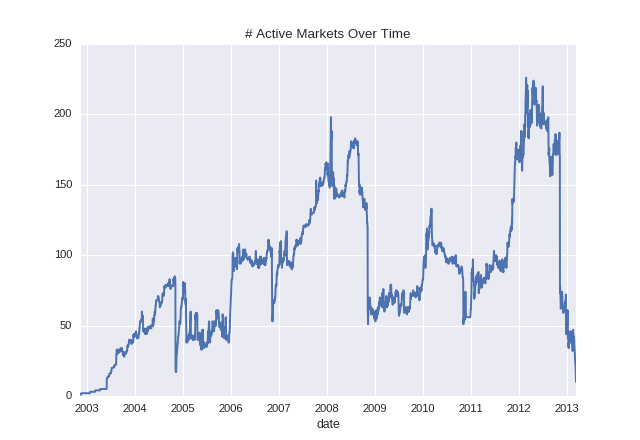

In [35]:
%matplotlib notebook
tradedays.groupby('date').market_id.count().plot()
plt.title('# Active Markets Over Time')

<IPython.core.display.Javascript object>


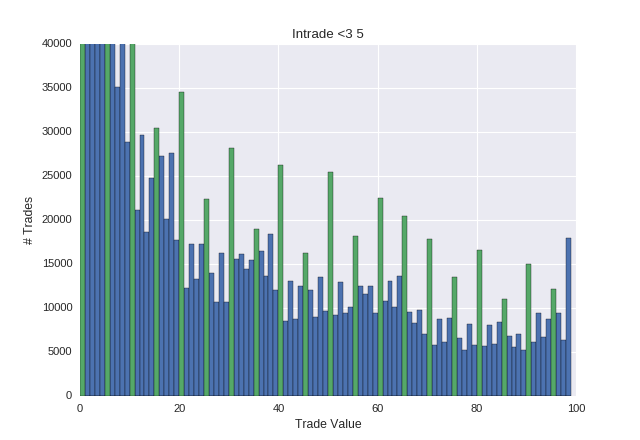

In [50]:
%matplotlib notebook
ax = plt.gca()
roundt = (100*trades.p).round(0)
roundt[roundt%5!=0].hist(bins=np.arange(100), ax=ax)
roundt[roundt%5==0].hist(bins=np.arange(100), ax=ax)
ax.set_ylim(0, 40000)
ax.set_title('Intrade <3 5')
ax.set_xlabel('Trade Value')
ax.set_ylabel('# Trades')

In [122]:
daygrp = tradedays.groupby('date')
volume = daygrp.trade_quantity.sum()
log_loss = -daygrp.log_loss.median()
vlowlog_loss = -daygrp.log_loss.quantile(0.05)
lowlog_loss = -daygrp.log_loss.quantile(0.25)
highlog_loss = -daygrp.log_loss.quantile(0.75)
vhighlog_loss = -daygrp.log_loss.quantile(0.95)

<IPython.core.display.Javascript object>


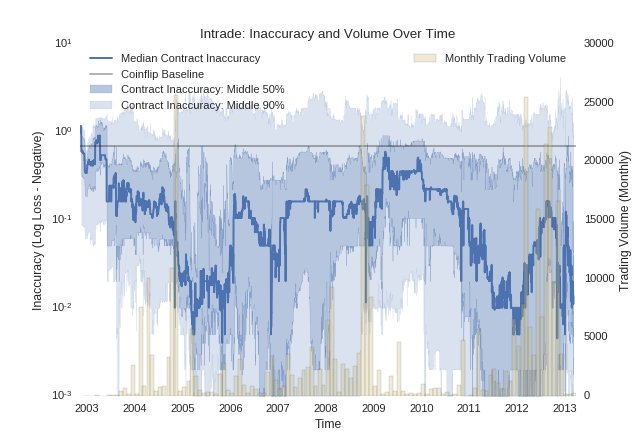

In [9]:
%matplotlib notebook
mvolume = volume.asfreq('M')
sns.set(rc={'figure.facecolor':'white', 'axes.facecolor':'white'})

colors = sns.color_palette()
colora = colors[0]
colorb = colors[4]

ax = plt.gca()
ax2 = ax.twinx()
ax.grid(False)
ax2.grid(False)
dates=log_loss.index
ax.set_yscale('log')

ax2.bar(mvolume.index, mvolume.values, color=colorb, width=30, alpha=0.3, label='Monthly Trading Volume')
ax.plot(log_loss.index, log_loss.values, '-', label='Median Contract Inaccuracy', color=colora)
ax.fill_between(dates, lowlog_loss, highlog_loss, alpha=.4, color=colora, label='Contract Inaccuracy: Middle 50%')
ax.fill_between(dates, vlowlog_loss, lowlog_loss, alpha=.2, color=colora, label='Contract Inaccuracy: Middle 90%')
ax.fill_between(dates, highlog_loss, vhighlog_loss, alpha=.2, color=colora)



ax.set_xlabel('Time')
ax.set_ylabel('Inaccuracy (Negative Log Loss)')
ax2.set_ylabel('Trading Volume (Monthly)')
ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='Coinflip Baseline')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_title("Intrade: Inaccuracy and Volume Over Time")

In [ ]:
def splitdf(df, col, val):
    df1 = df[df[col] < val]
    df2 = df[df[col] >= val]
    return df1, df2

def volume_filter(trades, minvolume):
    # filter out markets with less than minvolume total trading volume
    return trades[(mgroup(trades).trade_quantity.transform('sum') > minvolume)]

def duration_filter(df, timeunit, mintime):
    # filter out markets with less than mintime timeunits between first and last trade
    durargs = {timeunit: mintime}
    durfilter = (df.duration > pd.datetools.timedelta(**durargs))
    return df[durfilter]

def backfill(df, backup, cols, verbose=False):
    # fill in NAs by copying from the left. use backup to fill in the first column.
    for c in cols:
        df[c].iloc[:,0] = df[c].iloc[:,0].fillna(backup[c])
    i=1
    while df.isnull().any().any():
        if verbose:
            print '.',
        df[df.isnull()] = df.shift(i, axis=1)[df.isnull()]
        i = min(i*2, df.shape[1]-1)
    return df

def get_after(trades, mintime=-300, timeunit='hours', minvolume=500, cols=None):
    ncols = cols[:] or ['p']
    for c in ['market_id', timeunit]:
        if not c in cols:
            ncols.append(c)
    dtrades = duration_filter(trades, timeunit, -mintime) 
    tradesbefore, tradesafter = splitdf(dtrades, timeunit, mintime)
    tradesafter = volume_filter(tradesafter, minvolume)[ncols]
    prevp = mgroup(tradesbefore)[ncols].last()
    return tradesafter, prevp

def get_mtgrid(trades, prev_vals, timeunit, cols=None):
    cols = cols or ['p']
    # convert trades dataframe to market/time last-price-available dataframe
    #f = {col: 'last'}
    f = dict((c, 'last') for c in cols)
    binnedvals = trades.groupby(['market_id', timeunit]).agg(f)
    # move market_id and timespan to columns
    binnedvals.reset_index(inplace=True)
    mtgrid = binnedvals.pivot(index='market_id', columns=timeunit)
    mtgrid.sort_index(inplace=True)
    mtgrid = backfill(mtgrid, prev_vals, cols, verbose=True)
    return mtgrid
    
def trades_to_mtp(trades, timeunit='hours', mintime=-300, minvolume=500, cols=None):
    cols = cols or ['p']
    tradesafter, prevp = get_after(trades, mintime, timeunit, minvolume, cols)
    return get_mtgrid(tradesafter, prevp, timeunit, cols=cols)

def trades_to_tproi(trades, 
                    pricebins=10., 
                    timeunit='hours',  
                    mintime=-360,
                    timebins=30.,
                    minvolume=800):
    """Get DF with row for all market/time combinations, with long/short ROI cols
    
    params:
        trades: trades DF, as in get_trades()
        pricebins: how many price bins to have
        timeunit: 'hours' or 'days'
        timebins: how many time bins to have
        mintime: how far back before contract closing we want to look
        minvolume: all contracts with less than this much trading volume
            after mintime will be dropped
    returns:
        Return-on-investment DataFrame. 
        cols: market_id, hours_bin/days_bin, price_bin, roi_short, roi_long
    """
    timebin = timeunit + '_bin'
    mtprices = trades_to_mtprices(trades, timeunit, mintime, minvolume)
    finalprice = mtprices.iloc[:, -1]
    all_longs = 1.0/mtprices.div(finalprice, axis='rows')
    all_shorts = 1.0/( (100. - mtprices).div(100. - finalprice, axis='rows'))
    rounder = 100./pricebins
    rois = (np.floor(mtprices/rounder)*rounder).unstack().\
        reset_index().rename(columns={timeunit: timebin, 0: 'price_bin'})
    rois.loc[:, 'roi_long'] = all_longs.unstack().values
    rois.loc[:, 'roi_short'] = all_shorts.unstack().values
    rois = rois[rois[timebin].isin(np.arange(mintime, 0.1, -mintime/timebins))]
    return rois

In [27]:
trades.datetime_utc.diff().min()

Timedelta('0 days 00:00:00')

In [16]:
strades = trades[~trades.result.isnull()]
hourly = trades_to_mtp(strades, 
                       timeunit='hours', 
                       mintime=-(60*24), 
                       cols=['log_loss', 'final_year', 'result'], 
                       minvolume=200).stack('hours').reset_index()

/home/jai/.local/lib/python2.7/site-packages/pandas/core/indexing.py:508: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


. . . . . . . . . . .


In [133]:
td = pd.datetools.timedelta
last1400h = trades[(~trades.result.isnull()) & (trades.hours >= -1440) & (trades.duration > td(days=60))].copy()
last1400h.index = last1400h.hours.apply(lambda x: td(hours=x))
ll1400 = resample_trades(last1400h, '4H', prev_trades=trades[trades.hours < -1440])
ll1400['hours'] = ll1400.index
hb = ll1400.groupby('hours')

. . . . . . . . . . . . . . . . . . . . . . . .


In [193]:
llhours = hb.hours.first()/3600000000000
ll05 = -hb.log_loss.quantile(0.05)
ll25 = -hb.log_loss.quantile(0.25)
ll50 = -hb.log_loss.median()
ll75 = -hb.log_loss.quantile(0.75)
ll95 = -hb.log_loss.quantile(0.95)

<IPython.core.display.Javascript object>


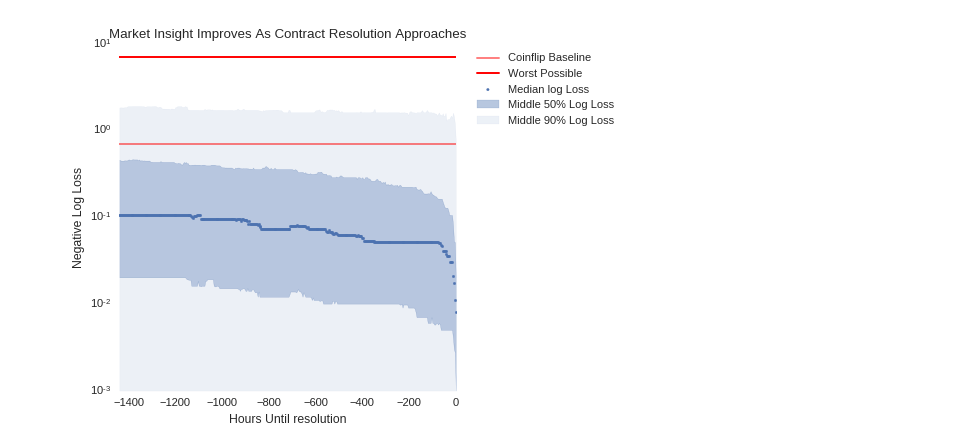

In [196]:
%matplotlib notebook

sns.set(rc={'figure.facecolor':'white', 'axes.facecolor':'white'})
fig = plt.figure()
ax = plt.subplot(1,2,1)
colors = sns.color_palette()
color = colors[0]
#hours = pd.date_range(start=0, periods=1441, freq='H')
# hours = np.arange(361)
hours = llhours
ax.scatter(hours, ll50, color=color, label='Median log Loss', marker='.')
ax.set_yscale('log')
ax.axhline(1, label='', alpha=0)
ax.axhline(-np.log(0.5), label='Coinflip Baseline', color='red', alpha=0.5)
ax.axhline(-np.log(0.001), label='Worst Possible', color='red')
ax.fill_between(hours, ll75, ll25, alpha=0.4, color=color, label='Middle 50% Log Loss')
ax.fill_between(hours, ll05, ll25, alpha=.1, color=color, label='Middle 90% Log Loss')
ax.fill_between(hours, ll75, ll95, alpha=.1, color=color)

# ax.legend()
ax.legend(fancybox=True, loc='upper right', shadow=True, ncol=1, bbox_to_anchor=(1.5, 1.0))
ax.set_xlim(hours.min(), hours.max())
ax.set_xlabel('Hours Until resolution')
ax.set_ylabel('Negative Log Loss')
ax.set_title('Market Insight Improves As Contract Resolution Approaches');
# f.tight_layout()

In [200]:
yh = ll1400.groupby(['final_year', 'hours'])
yearlyll = {}
for y in xrange(2004, 2013):
    ll = dict()
    data = ll1400[ll1400.final_year==y]
    hb = data.groupby('hours')
    ll['hours'] = hb.hours.first()/3600000000000
    ll['05'] = -hb.log_loss.quantile(0.05)
    ll['25'] = -hb.log_loss.quantile(0.25)
    ll['50'] = -hb.log_loss.median()
    ll['75'] = -hb.log_loss.quantile(0.75)
    ll['95'] = -hb.log_loss.quantile(0.95)
    yearlyll[y] = ll

<IPython.core.display.Javascript object>


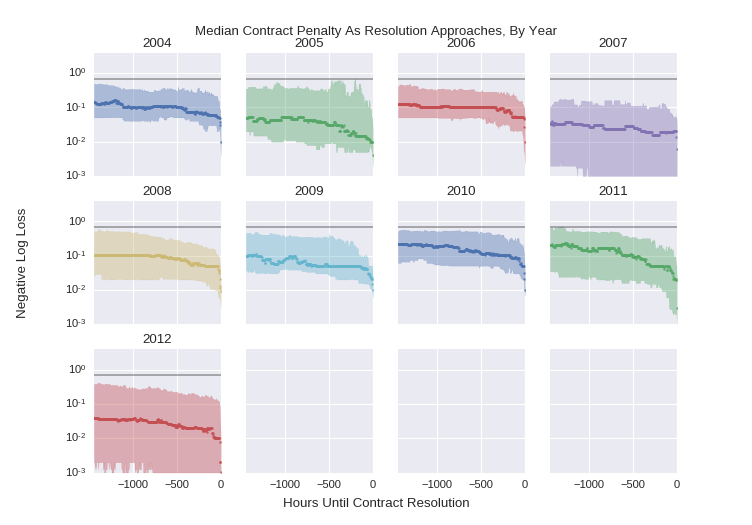

In [209]:
%matplotlib notebook
sns.set(rc={})

fig, axrows = plt.subplots(3, 4, sharex=True, sharey=True)
axes=[]
palette = sns.color_palette(n_colors=11)
for axrow in axrows:
    axes.extend(axrow)
for ax, y in zip(axes, yearlyll.iteritems()):
    color = palette.pop(0)
    year, ll = y
    sns.regplot(x=ll['hours'], y=ll['50'], fit_reg=False, ax=ax, label=year, marker='.', color=color)
    ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='coinflip baseline')
    ax.fill_between(ll['hours'], ll['25'], ll['75'], alpha=.4, color=color)
    ax.set_xlim(ll['hours'].min(), ll['hours'].max())
    ax.set_title(int(year))
    ax.locator_params(nbins=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
ax.set_yscale('log')
ax.set_ylim(0.001,4)
fig.text(0.5, 0.94, 'Median Contract Penalty As Resolution Approaches, By Year', ha='center', va='center')
fig.text(0.5, 0.04, 'Hours Until Contract Resolution', ha='center', va='center')
fig.text(0.03, 0.5, 'Negative Log Loss', ha='center', va='center', rotation='vertical')
# fig.tight_layout()

# Table of Contents
 <p><div class="lev1"><a href="#Boilerplate-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Boilerplate</a></div><div class="lev2"><a href="#Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></div><div class="lev2"><a href="#GetData-Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>GetData Functions</a></div><div class="lev2"><a href="#Get-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Get Data</a></div><div class="lev2"><a href="#Pickle-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Pickle</a></div><div class="lev3"><a href="#Load-Data-From-Pickles-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Load Data From Pickles</a></div><div class="lev2"><a href="#Colormaps-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Colormaps</a></div><div class="lev1"><a href="#Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></div><div class="lev2"><a href="#Categories-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Categories</a></div><div class="lev2"><a href="#Intrade-Lifetime-Analysis-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Intrade Lifetime Analysis</a></div><div class="lev3"><a href="#Active-Markets-Over-Time-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Active Markets Over Time</a></div>

# Boilerplate

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rpy2.robjects as rob
import seaborn as sns
from datetime import datetime
import os
import pickle
from scipy.special import logit
from tqdm import tqdm
import re
from itertools import islice

INTRADE_PATH = '/home/jai/Intrade-Contracts-NoFinancial/'

## GetData Functions

In [132]:
def read_trade_times(times):
    return [datetime.strptime(t, '%b/%d/%Y %H:%M:%S') for t in times]

def colname_fix(df):
    print 'Fixing column names...'
    columns = map(lambda x: re.sub(r'[\[\/\]]', '', x), df.columns)
    columns = map(lambda x: '_'.join(x.split(' ')), columns)
    df.rename(columns=dict(zip(df.columns, columns)), inplace=True)
    return df

def tradescsv_or_nothing(csv_path, intrade_path=INTRADE_PATH):
    try:
        df = pd.read_csv(csv_path, parse_dates=[5], date_parser=read_trade_times)
        category = csv_path.split(intrade_path)[1].split('/')[0]
        df['category'] = category
        return df
    except ValueError:
        return None
    
def get_trade_paths(intrade_path):
    trades=[]
    for dp, dn, fns in os.walk(intrade_path):
        sumfns = filter(lambda x: x.endswith('trades.csv'), fns)
        trades += map(lambda x: os.path.join(dp, x), sumfns)
    return trades

def hey(msg='hey'):
    def f(x):
        print msg
        return x
    return f

def read_trade_csvs(intrade_path):
    print 'Reading trade csvs...'
    readcsv = lambda csv_path: tradescsv_or_nothing(csv_path, intrade_path)
    return colname_fix(pd.concat(hey('Concatenating dfs...')(map(
                readcsv, 
                tqdm(get_trade_paths(intrade_path))
            ))))

def remove_weird_markets(trades):
    weird_mkts = \
        r'ELECTORALVOTES$|\-OPENING\.WEEKEND$|^LIV-EX100\.|^MEI.MOSES|^TOTAL.SEATS.|^ELEC.COL.VOTES'
    trades = trades[~trades.market_symbol.str.contains(weird_mkts)]
    trades = trades[~trades.market_id.isin((650479, 673548))]
    return trades.copy()

def mgroup(t):
    return t.groupby('market_id')

def mdgroup(t):
    return t.groupby(['market_id', 'days'])

def mhgroup(t):
    return t.groupby(['market_id', 'hours'])

logcache = dict()
def getlog(x):
    if x not in logcache:
        logcache[x] = np.log(x)
    return logcache[x]

def get_trades(path=INTRADE_PATH, trades=None, tradesfname=None):
    if tradesfname is not None:
        print 'loading raw trading data from pickle...',
        trades = pload(tradesfname)
    else:
        trades = trades or read_trade_csvs(path)
    trades = trades[~trades.trade_price.isnull()].copy()
    trades = remove_weird_markets(trades)
    alls = (lambda t=None: slice(None))
    assignments = [
        (alls, 'market_symbol', lambda t: t.market_symbol.astype('category')),
        (alls, 'market_name', lambda t: t.market_name.astype('category')),
        (alls, 'p', lambda t: t.trade_price/100.),
        (alls, 'final_time', lambda t: mgroup(t).datetime_utc.transform('max')),
        (alls, 'final_p', lambda t: t.p * (t.datetime_utc==t.final_time)),
        (alls, 'final_p', lambda t: mgroup(t).p.transform('max')),
        (alls, 'countdown', lambda t: t.datetime_utc - t.final_time),
        (alls, 'hours', lambda t: np.round(t.countdown.dt.total_seconds()/3600., 0)),
        (alls, 'days', lambda t: np.round(t.countdown.dt.total_seconds()/86400., 0)),
        (alls, 'result', lambda t: np.full(t.shape[0], np.nan)),
        (lambda t: t.final_p>=0.95, 'result', lambda t: 1),
        (lambda t: t.final_p<=0.05, 'result', lambda t: 0),
        (alls, 'year', lambda t: t.datetime_utc.dt.year),
        (alls, 'final_year', lambda t: t.final_time.dt.year),
        (alls, 'start_time', lambda t: mgroup(t).datetime_utc.transform('min')),
        (alls, 'duration', lambda t: t.final_time - t.start_time),
        (alls, 'lodds', lambda t: np.log(t.p/(1.0 - t.p))),
        (alls, 'log_loss', lambda t: np.nan),
        (lambda t: t.result==1, 'log_loss', lambda t: t.p.apply(getlog)),
        (lambda t: t.result==0, 'log_loss', lambda t: (1.0-t.p).apply(getlog))
    ]
    print 'Adding columns...'
    for rowf, col, getvals in assignments:
        print col,
        trades.loc[rowf(trades), col] = getvals(trades.loc[rowf(trades), :])
    trades.index = trades.datetime_utc
    print ' * sorting by datetime * ',
    trades.sort_index(inplace=True)
    return trades.copy()

def rs_sum_zero(data, ts='D'):
    """Resample data by sum, fill upsamples with 0"""
    return data.resample(ts, how='sum').fillna(0)

def fill_from_prev(trades, prev_trades):
    times = trades.index
    start = times.min()
    markets = trades.market_id.unique()
    covered_markets = trades[times==start].market_id.unique()
    tofill_markets = [m for m in markets if not m in covered_markets]
    last_entries = prev_trades[prev_trades.market_id.isin(tofill_markets)].groupby('market_id').last()
    last_entries.trade_quantity = 0
    last_entries['market_id'] = last_entries.index
    last_entries.index = pd.Series([start]*last_entries.shape[0])
    for c in ('datetime_utc', 'countdown', 'hours', 'days'):
        last_entries[c] = trades[c].min()
    return pd.concat((trades, last_entries))

def resample_trades(trades, ts='D', prev_trades=None):
    """Resample trades at some time frequency (default: calendar day)
    
    For most columns, take the last value each day and forward fill.
    For trade_quantity, same the sum each day and fill NAs with 0
    Add a "num_trades" column
    """
    if prev_trades is not None:
        trades = fill_from_prev(trades, prev_trades)
    trades = trades.copy()
    trades['num_trades'] = 1
    all_mtrades = []
    tsrules = dict((c, 'last') for c in trades.columns)
    tsrules['trade_quantity'] = 'sum'
    tsrules['num_trades'] = 'sum'
    trades.sort_values('market_id', inplace=True)
    for m in trades.market_id.unique():
        if np.random.random() < 0.02:
            print '.',
        mtrades = trades[trades.market_id==m]
        mquantity = rs_sum_zero(mtrades.trade_quantity)
        mnumtrades = rs_sum_zero(mtrades.num_trades)
        mdtrades = mtrades.resample(ts, how=tsrules, fill_method='ffill')
        mdtrades.trade_quantity = mquantity
        mdtrades.num_trades = mnumtrades
        all_mtrades.append(mdtrades)
    dtrades = pd.concat(all_mtrades)
    trades.sort_index(inplace=True)
    return dtrades

def get_market_info(trades):
    mt = mgroup(trades)
    market_info = mt.last()[[
        'market_symbol', 
        'market_name', 
        'category', 
        'final_time', 
        'start_time', 
        'final_p', 
        'duration',
        'final_year',
        'result'
    ]]
    market_info['total_volume'] = mt.trade_quantity.sum()
    market_info['num_trades'] = mt.market_id.count()
    return market_info

def get_trade_days(trades, market_info):
    tradedays = resample_trades(
        trades[resolved_filter].loc[
            :, 
            ['market_id', 'p', 'trade_quantity']])
    tradedays = tradedays.merge(market_info, left_on='market_id', right_index=True)
    tradedays = tradedays[~tradedays.result.isnull()]
    tradedays['log_loss'] = np.nan
    tradedays.loc[tradedays.result==1, 'log_loss'] = np.log(tradedays.loc[tradedays.result==1, 'p'])
    tradedays.loc[tradedays.result==0, 'log_loss'] = np.log(1. - tradedays.loc[tradedays.result==0, 'p'])
    tradedays['date'] = tradedays.index
    return tradedays

## Get Data

In [145]:
trades = get_trades(tradesfname='raw_trades')

loading raw trading data from pickle... Adding columns...
market_symbol market_name p final_time final_p final_p countdown hours days result result result year final_year start_time duration lodds log_loss log_loss log_loss  * sorting by datetime * 


In [153]:
market_info = get_market_info(trades)

In [ ]:
tradedays = get_trade_days(trades, market_info)

## Pickle

In [3]:
def ppath(name, base=INTRADE_PATH):
    return os.path.join(base, name + '.pickle')

def pdump(thing, name):
    with open(ppath(name), 'w+') as f:
        pickle.dump(thing, f, pickle.HIGHEST_PROTOCOL)

def pload(name):
    with open(ppath(name)) as f:
        x = pickle.load(f)
    return x

In [156]:
pdump(market_info, 'market_info')

In [157]:
pdump(raw_trades, 'raw_trades')

In [158]:
pdump(trades, 'trades')

In [160]:
pdump(tradedays, 'tradedays')

### Load Data From Pickles

In [7]:
trades = pload('trades')
market_info = pload('market_info')
tradedays = pload('tradedays')

## Colormaps

In [4]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    np.logspace
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap
cmap = sns.diverging_palette(h_neg=15, h_pos=255, s=99, l=35, sep=1, n=15, as_cmap=True)
scmap = shiftedColorMap(cmap, start=0.0, midpoint=0.33, stop=1.0)

# Analysis

## Categories

<IPython.core.display.Javascript object>


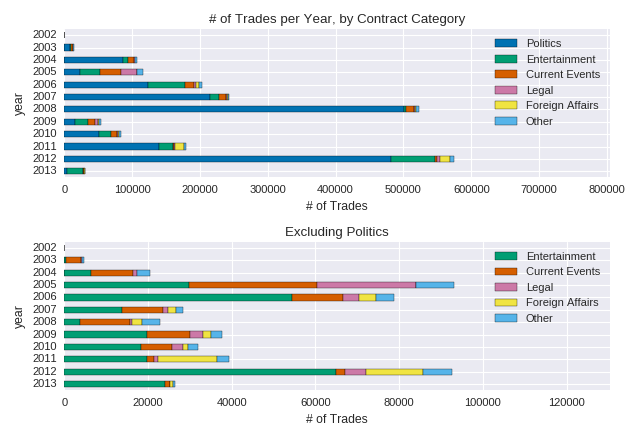

In [164]:
%matplotlib notebook

sns.set()

ncats = 5

color = sns.color_palette('colorblind', n_colors=(ncats+1))

f, (ax1, ax2) = plt.subplots(2,1, sharex=False, sharey=False)
catcounts = trades.groupby('category').market_id.count().sort_values(ascending=False)
bigcats = catcounts.index[:ncats]
smallcats = catcounts.index[ncats:]
catyears=trades.groupby(['year', 'category']).market_id.count().unstack('category')
smallcatcounts = catyears[smallcats].sum(axis=1)
catyears = catyears[bigcats]
catyears['Other'] = smallcatcounts
catyears.fillna(0, inplace=True)
catyears.sort_index(inplace=True, ascending=False)
ax1.grid(True)
catyears.plot.barh(stacked=True, color=color, ax=ax1)
ax1.legend(loc='upper right')
ax1.set_title('# of Trades per Year, by Contract Category')
ax1.set_xlim(0, max(catyears.sum(axis=1))*1.4)
ax1.set_xlabel('# of Trades')


othercats = filter(lambda cat: 'politics' not in cat.lower(), catyears.columns)
catyearsnp = catyears.loc[:, othercats]
catyearsnp.plot.barh(stacked=True, color=color[1:], ax=ax2)
ax2.legend(loc='upper right')
ax2.set_title('Excluding Politics');
ax2.set_xlim(0, max(catyearsnp.sum(axis=1))*1.4)
ax2.set_xlabel('# of Trades')
f.tight_layout()

## Intrade Lifetime Analysis

### Active Markets Over Time

<IPython.core.display.Javascript object>


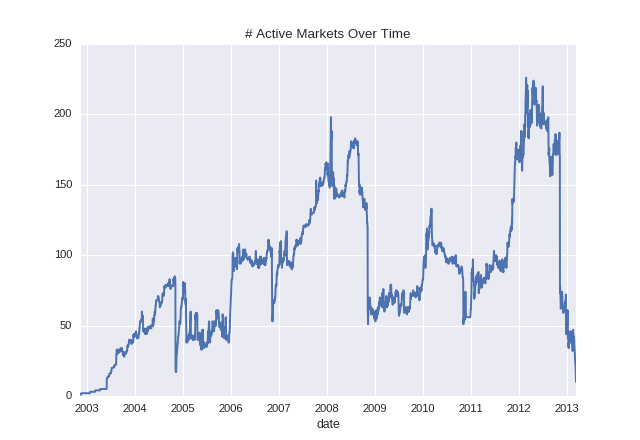

In [35]:
%matplotlib notebook
tradedays.groupby('date').market_id.count().plot()
plt.title('# Active Markets Over Time')

<IPython.core.display.Javascript object>


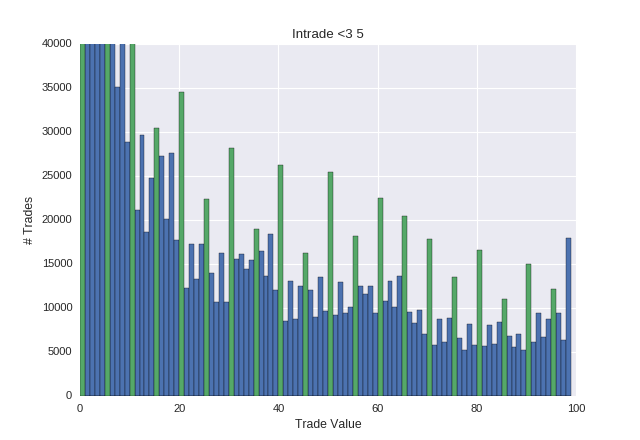

In [50]:
%matplotlib notebook
ax = plt.gca()
roundt = (100*trades.p).round(0)
roundt[roundt%5!=0].hist(bins=np.arange(100), ax=ax)
roundt[roundt%5==0].hist(bins=np.arange(100), ax=ax)
ax.set_ylim(0, 40000)
ax.set_title('Intrade <3 5')
ax.set_xlabel('Trade Value')
ax.set_ylabel('# Trades')

In [122]:
daygrp = tradedays.groupby('date')
volume = daygrp.trade_quantity.sum()
log_loss = -daygrp.log_loss.median()
vlowlog_loss = -daygrp.log_loss.quantile(0.05)
lowlog_loss = -daygrp.log_loss.quantile(0.25)
highlog_loss = -daygrp.log_loss.quantile(0.75)
vhighlog_loss = -daygrp.log_loss.quantile(0.95)

<IPython.core.display.Javascript object>


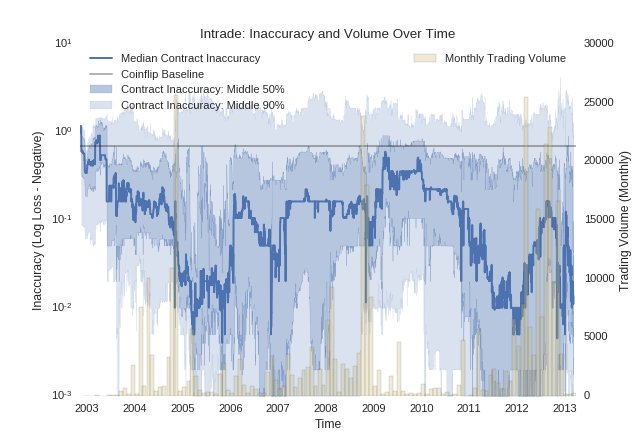

In [9]:
%matplotlib notebook
mvolume = volume.asfreq('M')
sns.set(rc={'figure.facecolor':'white', 'axes.facecolor':'white'})

colors = sns.color_palette()
colora = colors[0]
colorb = colors[4]

ax = plt.gca()
ax2 = ax.twinx()
ax.grid(False)
ax2.grid(False)
dates=log_loss.index
ax.set_yscale('log')

ax2.bar(mvolume.index, mvolume.values, color=colorb, width=30, alpha=0.3, label='Monthly Trading Volume')
ax.plot(log_loss.index, log_loss.values, '-', label='Median Contract Inaccuracy', color=colora)
ax.fill_between(dates, lowlog_loss, highlog_loss, alpha=.4, color=colora, label='Contract Inaccuracy: Middle 50%')
ax.fill_between(dates, vlowlog_loss, lowlog_loss, alpha=.2, color=colora, label='Contract Inaccuracy: Middle 90%')
ax.fill_between(dates, highlog_loss, vhighlog_loss, alpha=.2, color=colora)



ax.set_xlabel('Time')
ax.set_ylabel('Inaccuracy (Negative Log Loss)')
ax2.set_ylabel('Trading Volume (Monthly)')
ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='Coinflip Baseline')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_title("Intrade: Inaccuracy and Volume Over Time")

In [ ]:
def splitdf(df, col, val):
    df1 = df[df[col] < val]
    df2 = df[df[col] >= val]
    return df1, df2

def volume_filter(trades, minvolume):
    # filter out markets with less than minvolume total trading volume
    return trades[(mgroup(trades).trade_quantity.transform('sum') > minvolume)]

def duration_filter(df, timeunit, mintime):
    # filter out markets with less than mintime timeunits between first and last trade
    durargs = {timeunit: mintime}
    durfilter = (df.duration > pd.datetools.timedelta(**durargs))
    return df[durfilter]

def backfill(df, backup, cols, verbose=False):
    # fill in NAs by copying from the left. use backup to fill in the first column.
    for c in cols:
        df[c].iloc[:,0] = df[c].iloc[:,0].fillna(backup[c])
    i=1
    while df.isnull().any().any():
        if verbose:
            print '.',
        df[df.isnull()] = df.shift(i, axis=1)[df.isnull()]
        i = min(i*2, df.shape[1]-1)
    return df

def get_after(trades, mintime=-300, timeunit='hours', minvolume=500, cols=None):
    ncols = cols[:] or ['p']
    for c in ['market_id', timeunit]:
        if not c in cols:
            ncols.append(c)
    dtrades = duration_filter(trades, timeunit, -mintime) 
    tradesbefore, tradesafter = splitdf(dtrades, timeunit, mintime)
    tradesafter = volume_filter(tradesafter, minvolume)[ncols]
    prevp = mgroup(tradesbefore)[ncols].last()
    return tradesafter, prevp

def get_mtgrid(trades, prev_vals, timeunit, cols=None):
    cols = cols or ['p']
    # convert trades dataframe to market/time last-price-available dataframe
    #f = {col: 'last'}
    f = dict((c, 'last') for c in cols)
    binnedvals = trades.groupby(['market_id', timeunit]).agg(f)
    # move market_id and timespan to columns
    binnedvals.reset_index(inplace=True)
    mtgrid = binnedvals.pivot(index='market_id', columns=timeunit)
    mtgrid.sort_index(inplace=True)
    mtgrid = backfill(mtgrid, prev_vals, cols, verbose=True)
    return mtgrid
    
def trades_to_mtp(trades, timeunit='hours', mintime=-300, minvolume=500, cols=None):
    cols = cols or ['p']
    tradesafter, prevp = get_after(trades, mintime, timeunit, minvolume, cols)
    return get_mtgrid(tradesafter, prevp, timeunit, cols=cols)

def trades_to_tproi(trades, 
                    pricebins=10., 
                    timeunit='hours',  
                    mintime=-360,
                    timebins=30.,
                    minvolume=800):
    """Get DF with row for all market/time combinations, with long/short ROI cols
    
    params:
        trades: trades DF, as in get_trades()
        pricebins: how many price bins to have
        timeunit: 'hours' or 'days'
        timebins: how many time bins to have
        mintime: how far back before contract closing we want to look
        minvolume: all contracts with less than this much trading volume
            after mintime will be dropped
    returns:
        Return-on-investment DataFrame. 
        cols: market_id, hours_bin/days_bin, price_bin, roi_short, roi_long
    """
    timebin = timeunit + '_bin'
    mtprices = trades_to_mtprices(trades, timeunit, mintime, minvolume)
    finalprice = mtprices.iloc[:, -1]
    all_longs = 1.0/mtprices.div(finalprice, axis='rows')
    all_shorts = 1.0/( (100. - mtprices).div(100. - finalprice, axis='rows'))
    rounder = 100./pricebins
    rois = (np.floor(mtprices/rounder)*rounder).unstack().\
        reset_index().rename(columns={timeunit: timebin, 0: 'price_bin'})
    rois.loc[:, 'roi_long'] = all_longs.unstack().values
    rois.loc[:, 'roi_short'] = all_shorts.unstack().values
    rois = rois[rois[timebin].isin(np.arange(mintime, 0.1, -mintime/timebins))]
    return rois

In [27]:
trades.datetime_utc.diff().min()

Timedelta('0 days 00:00:00')

In [16]:
strades = trades[~trades.result.isnull()]
hourly = trades_to_mtp(strades, 
                       timeunit='hours', 
                       mintime=-(60*24), 
                       cols=['log_loss', 'final_year', 'result'], 
                       minvolume=200).stack('hours').reset_index()

/home/jai/.local/lib/python2.7/site-packages/pandas/core/indexing.py:508: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


. . . . . . . . . . .


In [133]:
td = pd.datetools.timedelta
last1400h = trades[(~trades.result.isnull()) & (trades.hours >= -1440) & (trades.duration > td(days=60))].copy()
last1400h.index = last1400h.hours.apply(lambda x: td(hours=x))
ll1400 = resample_trades(last1400h, '4H', prev_trades=trades[trades.hours < -1440])
ll1400['hours'] = ll1400.index
hb = ll1400.groupby('hours')

. . . . . . . . . . . . . . . . . . . . . . . .


In [193]:
llhours = hb.hours.first()/3600000000000
ll05 = -hb.log_loss.quantile(0.05)
ll25 = -hb.log_loss.quantile(0.25)
ll50 = -hb.log_loss.median()
ll75 = -hb.log_loss.quantile(0.75)
ll95 = -hb.log_loss.quantile(0.95)

<IPython.core.display.Javascript object>


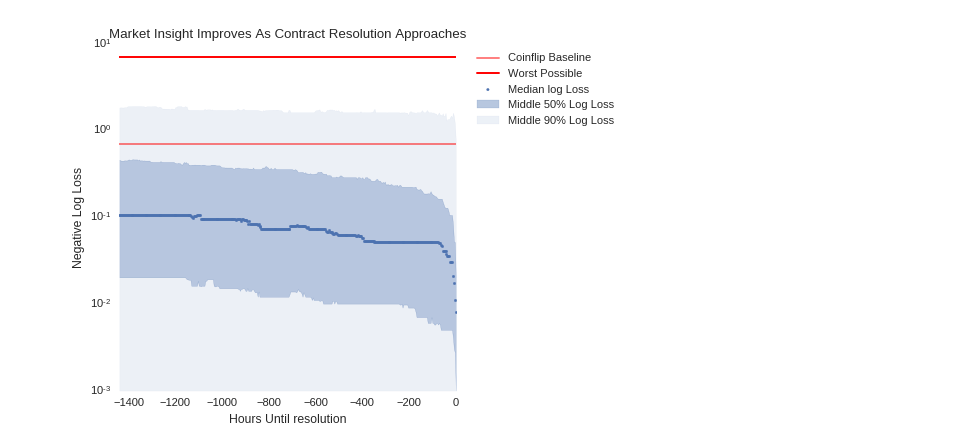

In [196]:
%matplotlib notebook

sns.set(rc={'figure.facecolor':'white', 'axes.facecolor':'white'})
fig = plt.figure()
ax = plt.subplot(1,2,1)
colors = sns.color_palette()
color = colors[0]
#hours = pd.date_range(start=0, periods=1441, freq='H')
# hours = np.arange(361)
hours = llhours
ax.scatter(hours, ll50, color=color, label='Median log Loss', marker='.')
ax.set_yscale('log')
ax.axhline(1, label='', alpha=0)
ax.axhline(-np.log(0.5), label='Coinflip Baseline', color='red', alpha=0.5)
ax.axhline(-np.log(0.001), label='Worst Possible', color='red')
ax.fill_between(hours, ll75, ll25, alpha=0.4, color=color, label='Middle 50% Log Loss')
ax.fill_between(hours, ll05, ll25, alpha=.1, color=color, label='Middle 90% Log Loss')
ax.fill_between(hours, ll75, ll95, alpha=.1, color=color)

# ax.legend()
ax.legend(fancybox=True, loc='upper right', shadow=True, ncol=1, bbox_to_anchor=(1.5, 1.0))
ax.set_xlim(hours.min(), hours.max())
ax.set_xlabel('Hours Until resolution')
ax.set_ylabel('Negative Log Loss')
ax.set_title('Market Insight Improves As Contract Resolution Approaches');
# f.tight_layout()

In [200]:
yh = ll1400.groupby(['final_year', 'hours'])
yearlyll = {}
for y in xrange(2004, 2013):
    ll = dict()
    data = ll1400[ll1400.final_year==y]
    hb = data.groupby('hours')
    ll['hours'] = hb.hours.first()/3600000000000
    ll['05'] = -hb.log_loss.quantile(0.05)
    ll['25'] = -hb.log_loss.quantile(0.25)
    ll['50'] = -hb.log_loss.median()
    ll['75'] = -hb.log_loss.quantile(0.75)
    ll['95'] = -hb.log_loss.quantile(0.95)
    yearlyll[y] = ll

<IPython.core.display.Javascript object>


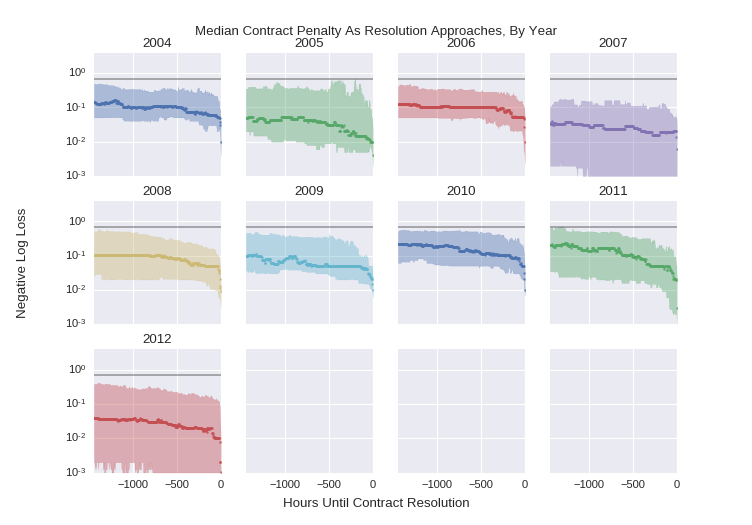

In [209]:
%matplotlib notebook
sns.set(rc={})

fig, axrows = plt.subplots(3, 4, sharex=True, sharey=True)
axes=[]
palette = sns.color_palette(n_colors=11)
for axrow in axrows:
    axes.extend(axrow)
for ax, y in zip(axes, yearlyll.iteritems()):
    color = palette.pop(0)
    year, ll = y
    sns.regplot(x=ll['hours'], y=ll['50'], fit_reg=False, ax=ax, label=year, marker='.', color=color)
    ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='coinflip baseline')
    ax.fill_between(ll['hours'], ll['25'], ll['75'], alpha=.4, color=color)
    ax.set_xlim(ll['hours'].min(), ll['hours'].max())
    ax.set_title(int(year))
    ax.locator_params(nbins=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
ax.set_yscale('log')
ax.set_ylim(0.001,4)
fig.text(0.5, 0.94, 'Median Contract Penalty As Resolution Approaches, By Year', ha='center', va='center')
fig.text(0.5, 0.04, 'Hours Until Contract Resolution', ha='center', va='center')
fig.text(0.03, 0.5, 'Negative Log Loss', ha='center', va='center', rotation='vertical')

In [210]:
ch = ll1400.groupby(['category', 'hours'])
catll = {}
cats = ('Politics', 'Entertainment', 'Current Events', 'Legal', 'Foreign Affairs')
for c in cats:
    ll = dict()
    data = ll1400[ll1400.category==c]
    hb = data.groupby('hours')
    ll['hours'] = hb.hours.first()/3600000000000
    ll['05'] = -hb.log_loss.quantile(0.05)
    ll['25'] = -hb.log_loss.quantile(0.25)
    ll['50'] = -hb.log_loss.median()
    ll['75'] = -hb.log_loss.quantile(0.75)
    ll['95'] = -hb.log_loss.quantile(0.95)
    catll[c] = ll

<IPython.core.display.Javascript object>


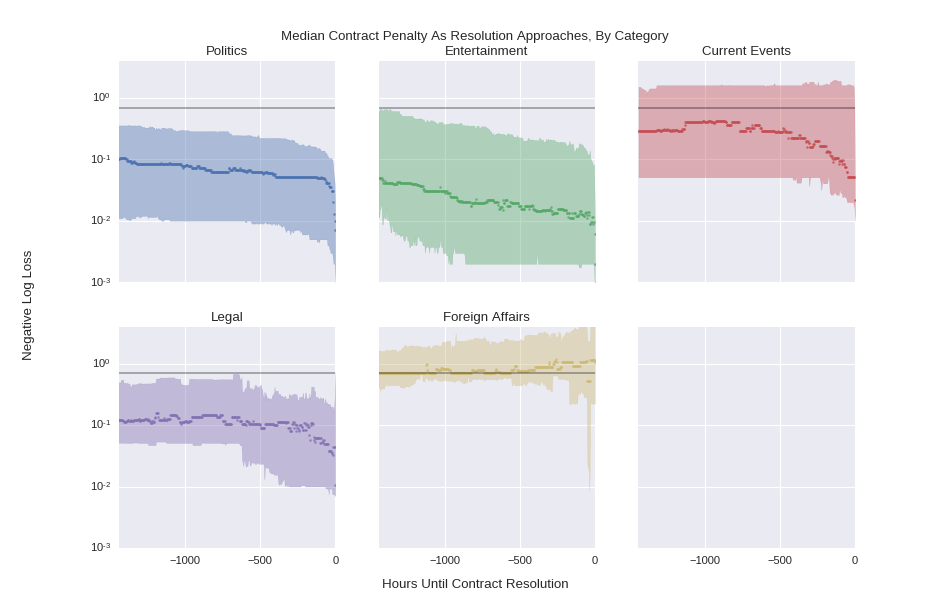

In [214]:
%matplotlib notebook
sns.set(rc={})

fig, axrows = plt.subplots(2, 3, sharex=True, sharey=True)
axes=[]
palette = sns.color_palette(n_colors=11)
for axrow in axrows:
    axes.extend(axrow)
for ax, cat in zip(axes, cats):
    color = palette.pop(0)
    ll = catll[cat]
    sns.regplot(x=ll['hours'], y=ll['50'], fit_reg=False, ax=ax, label=cat, marker='.', color=color)
    ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='coinflip baseline')
    ax.fill_between(ll['hours'], ll['25'], ll['75'], alpha=.4, color=color)
    ax.set_xlim(ll['hours'].min(), ll['hours'].max())
    ax.set_title(cat)
    ax.locator_params(nbins=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
ax.set_yscale('log')
ax.set_ylim(0.001,4)
fig.text(0.5, 0.94, 'Median Contract Penalty As Resolution Approaches, By Category', ha='center', va='center')
fig.text(0.5, 0.04, 'Hours Until Contract Resolution', ha='center', va='center')
fig.text(0.03, 0.5, 'Negative Log Loss', ha='center', va='center', rotation='vertical')

In [ ]:
rois = trades_to_tproi(trades, pricebins=20)

In [ ]:
def get_samplesize(df, xbin='hours_bin', ybin='price_bin'):
    ss = df.groupby([ybin, xbin]).market_id.nunique().unstack()
    ss.fillna(0, inplace=True)
    return ss.astype('int')

def plot_rois(rois, timebin='hours_bin', cmap=scmap, samplesize=False):
    longs=rois.groupby(['price_bin', timebin]).roi_long.mean().unstack()
    shorts=rois.groupby(['price_bin', timebin]).roi_short.mean().unstack()
    shorts=shorts.iloc[::-1,:]
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False)
    cbar_ax = f.add_axes([.91, .3, .03, .4])
    sns.set(rc={'figure.facecolor':'white', 'axes.facecolor':'white'})

    hmargs = {
        'cmap': cmap,
        'vmin': 0.5,
        'vmax': 2.0,
        'robust': False,
        'yticklabels': 2,
        'xticklabels': 2,
    }
    if samplesize:
        samplesize = get_samplesize(rois)
        allfalse = np.full(samplesize.shape, False)
        sns.heatmap(samplesize, ax=ax1, mask=allfalse, annot=True, fmt='d', cbar=False)
        sns.heatmap(samplesize, ax=ax2, mask=allfalse, annot=True, fmt='d', cbar=False)
    sns.heatmap(longs, ax=ax1, cbar_ax=cbar_ax, **hmargs)
    ax1.set_title('ROI Long (Flat)');
    ax1.set_xlabel('')
    sns.heatmap(shorts, ax=ax2, cbar_ax=cbar_ax, **hmargs)
    ax2.set_title('ROI Short (Flat)');
    f.tight_layout(rect=[0, 0, 0.9, 1])
    f.set_facecolor('white')
    return ax1, ax2

def plot_samplesize(df, xbin='hours_bin', ybin='price_bin'):
    samplesize = get_samplesize(df, xbin, ybin)
    allfalse = np.full(samplesize.shape, False)
    sns.heatmap(samplesize, annot=True, fmt='d', mask=allfalse, cbar=False, ax=ax,
                 vmin=10, vmax=500,cmap="YlGnBu", norm=matplotlib.colors.LogNorm()
               );
    sns.heatmap(samplesize, vmin=10, vmax=500,cmap="YlGnBu", cbar=False, ax=ax,
                norm=matplotlib.colors.LogNorm(), xticklabels=2, yticklabels=2);
    plt.title('# of Contracts at Price Level Over Time')
    plt.xlabel(xbin)
    plt.ylabel(ybin);

<IPython.core.display.Javascript object>


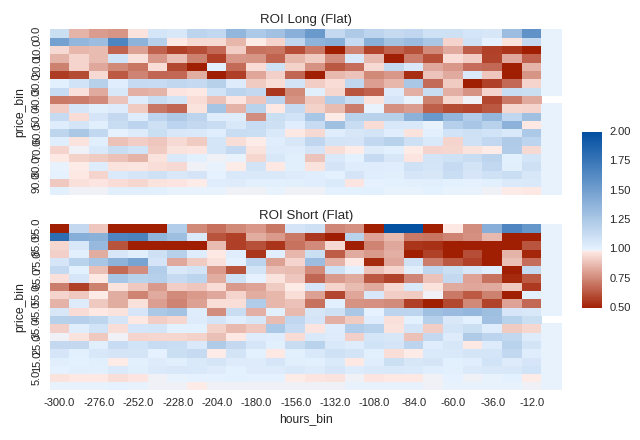

In [173]:
%matplotlib notebook
plot_rois(rois);

In [320]:
%matplotlib notebook
plot_samplesize(rois);

NameError: name 'rois' is not defined

In [192]:
# what's that blue thing about 80 hours out near 100% on the ROI short graph?
surething=trades[(trades.hours > -100) & 
                 (trades.hours < -80) & 
                 (trades.final_price<10) & 
                 (trades.trade_price>90) &
                 (trades.cum_volume>100)
                ]
surething.market_name.unique()
# oh, apparently it's Mitt Romney

array(['Mitt Romney to win the 2012 South Carolina Primary',
       'Mitt Romney to win Iowa  New Hampshire  South Carolina  Florida and Nevada primaries/cacuses in 2012',
       'Mitt Romney to win the 2012 Colorado Caucus',
       'American Reunion to gross OVER $25.0M in opening weekend',
       'The Dark Knight Rises to gross OVER $165.0M in opening weekend',
       'The Dark Knight Rises to gross OVER $170.0M in opening weekend',
       'Republicans to hold 46 or more seats after 2012 elections',
       'The Hobbit to gross OVER $85.0M in opening weekend'], dtype=object)

In [185]:
election_years = (2008, 2012)
off_years = (2005, 2006, 2007, 2009, 2010, 2011)
yearsets = ((2005, 2006, 2007), (2008,), (2009, 2010, 2011), (2012,))
yearly_trades = map(lambda x: trades[trades.final_year.isin(x)], (election_years, off_years))
custom_tproi = lambda t: trades_to_tproi(t, pricebins=4)
yearly_rois = map(custom_tproi, yearly_trades)
#f, (axes) = plt.get_sub
#f, (ax05, ax08, ax09, ax12) = plt.subplots(4, 1, sharex=True, sharey=False)

{'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . . {'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . .


<IPython.core.display.Javascript object>


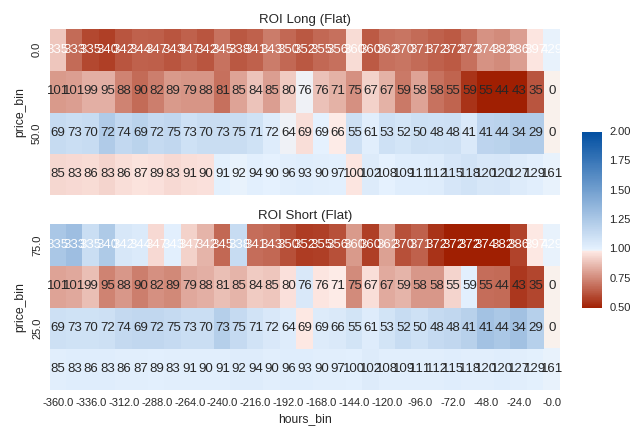

/home/jai/.local/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


<IPython.core.display.Javascript object>


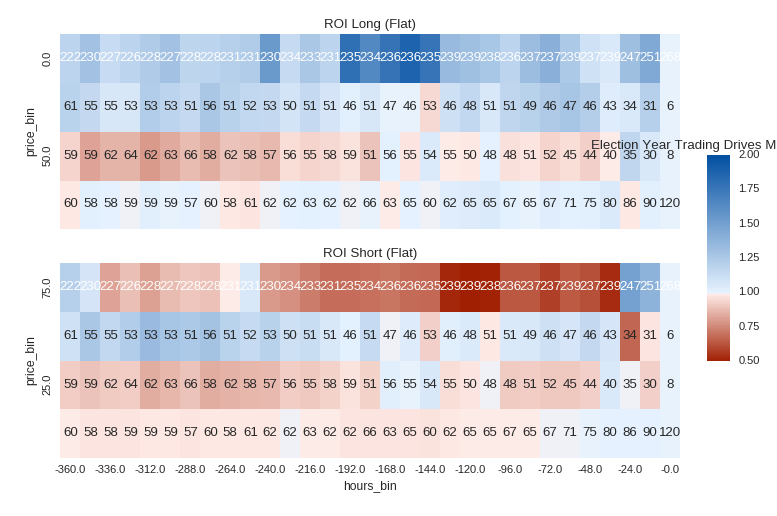

In [186]:
%matplotlib notebook
for roi in yearly_rois:
    plot_rois(roi, samplesize=True)
plt.title('Election Year Trading Drives Miscalibration')

{'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . . {'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . .

<IPython.core.display.Javascript object>


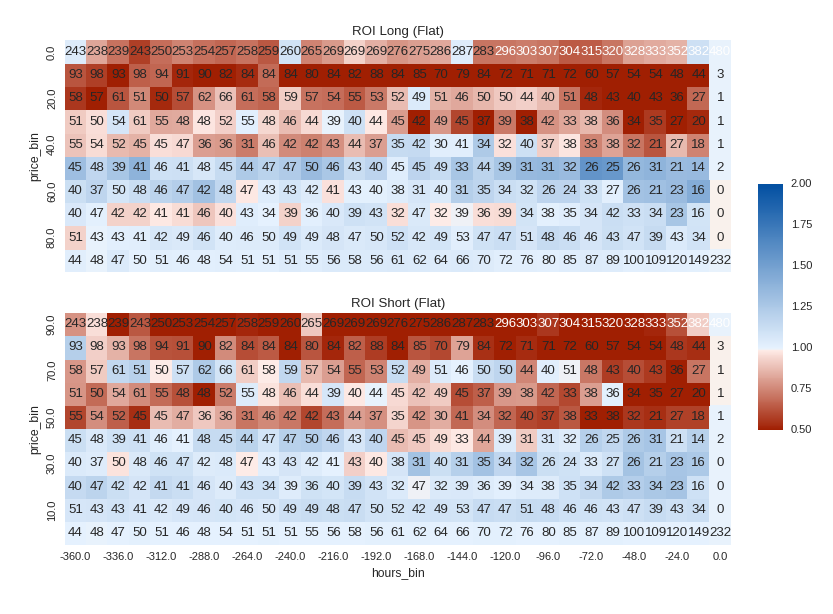

<IPython.core.display.Javascript object>


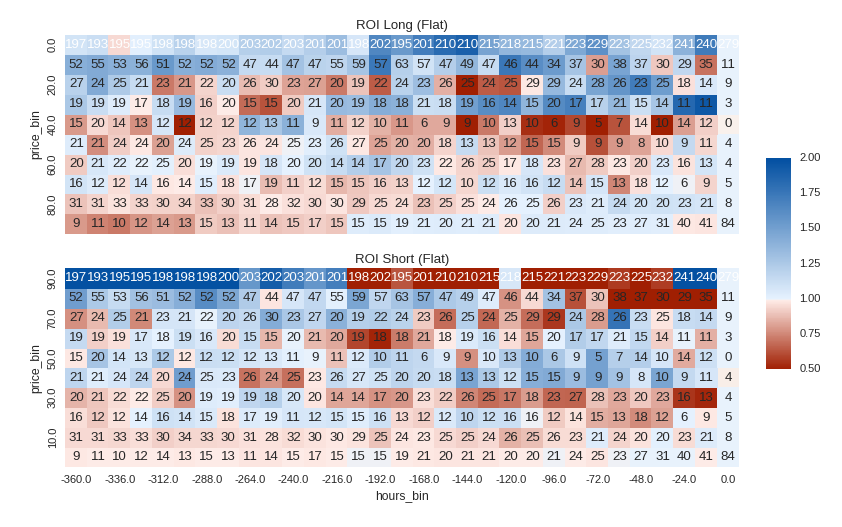

(<matplotlib.axes._subplots.AxesSubplot at 0x7f82b9e28ad0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f82b03eb2d0>)

In [187]:
%matplotlib notebook
ptrades = trades[trades.category=='Politics']
nptrades = trades[~(trades.category=='Politics')]
proi, nproi = map(trades_to_tproi, (ptrades, nptrades))
plot_rois(proi, samplesize=True)
plot_rois(nproi, samplesize=True)

{'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . . {'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . .

<IPython.core.display.Javascript object>


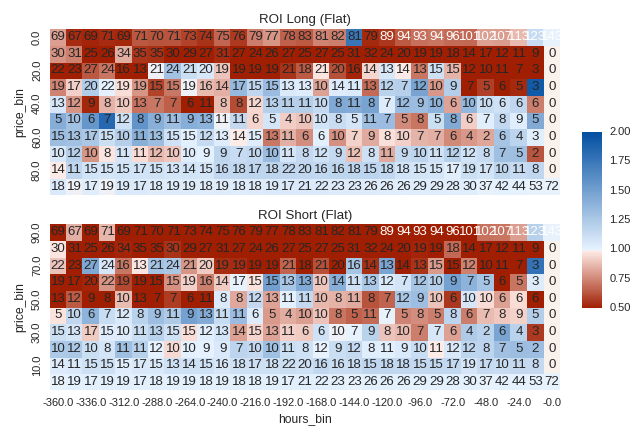

<IPython.core.display.Javascript object>


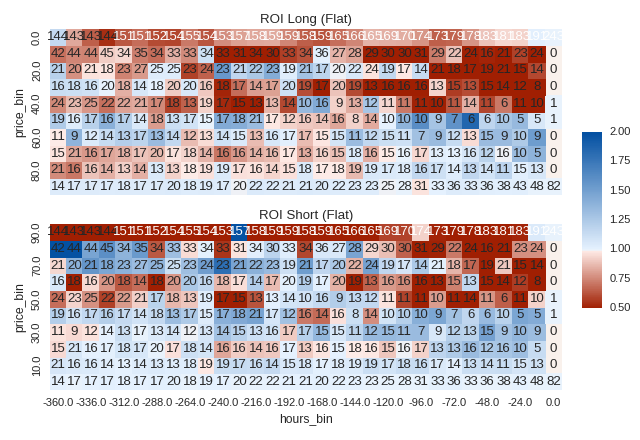

(<matplotlib.axes._subplots.AxesSubplot at 0x7f82c7790fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f82b8b64f50>)

In [188]:
%matplotlib notebook
ptrades08 = ptrades[ptrades.final_year.isin((2008, 2009))]
ptrades12 = ptrades[ptrades.final_year.isin((2012, 2013))]
roi08, roi12 = map(trades_to_tproi, (ptrades08, ptrades12))
plot_rois(roi08, samplesize=True)
plot_rois(roi12, samplesize=True)

In [189]:
%matplotlib notebook
print '.',
ptrades_us = ptrades[~ptrades.market_symbol.str.contains(r'LIB-?DEMS?\.|EASTLEIGH')]
print '.',
ptrades_us = ptrades_us[~ptrades_us.market_symbol.str.startswith('UK.')]
ptrades_us = ptrades_us[~ptrades_us.market_symbol.str.startswith('LON.')]

print '.',
ptradesd = ptrades_us[ptrades_us.market_name.str.contains(r'Obama|Clinton|Edwards|Democrat|Biden|DNC')]
print '.',
ptradesr = ptrades_us[ptrades_us.market_name.str.contains(r'Bush|McCain|Palin|Romney|Paul|RNC|Republican')]

. . . .


In [272]:
print roid.roi_short.min(), roid.roi_short.max()
print roid.roi_long.min(), roid.roi_long.max()

print roid.roi_short.min(), roid.roi_short.max()
print roid.roi_long.min(), roid.roi_long.max() 

 0.00115606936416 25.4102564103
0.00111234705228 49.3


{'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . . {'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . .

<IPython.core.display.Javascript object>


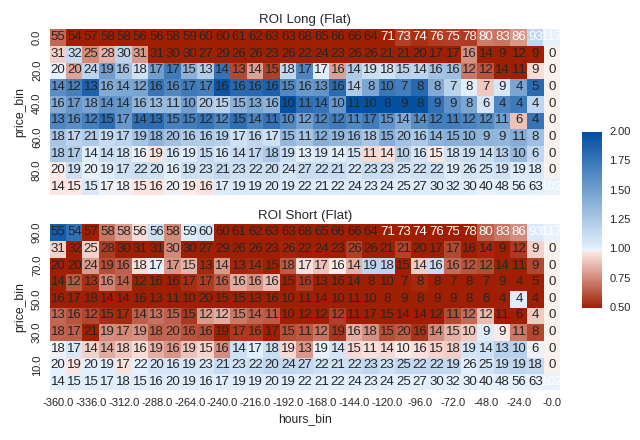

<IPython.core.display.Javascript object>


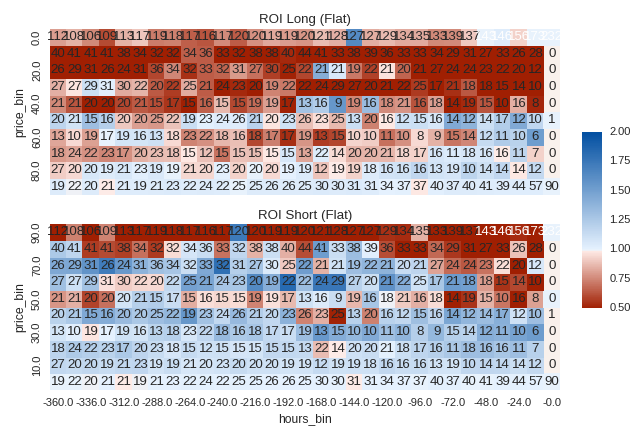

(<matplotlib.axes._subplots.AxesSubplot at 0x7f82cd94e410>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f82b385b350>)

In [190]:
roid, roir = map(trades_to_tproi, (ptradesd, ptradesr))
plot_rois(roid, samplesize=True)
plot_rois(roir, samplesize=True)

In [214]:
known = (~trades.result.isnull())
last10dfilter = (trades.countdown > -pd.datetools.timedelta(days=10))
ttrades = trades[known & last10dfilter]
highfilter = (ttrades.trade_price > 90.)
lofilter = (ttrades.trade_price < 10.)
highs = ttrades[highfilter]
lows = ttrades[lofilter]
highcost = (highs.trade_price*highs.trade_quantity).sum()
highreturn = (100*highs.result*highs.trade_quantity).sum()
print highcost, highreturn, highreturn-highcost, highreturn/highcost

lowcost = ((100. - lows.trade_price)*lows.trade_quantity).sum()
lowreturn = (100*(lows.result==0)*lows.trade_quantity).sum()
print lowcost, lowreturn, lowreturn-lowcost, lowreturn/lowcost

102610246.5 104577300.0 1967053.5 1.01917014691
300616918.9 304833900 4216981.1 1.01402775704


In [12]:
knowntrades = trades[~(trades.result.isnull())]

In [13]:
def get_ledger(trades, rule, style='long'):
    cols = ['trade_price', 'trade_quantity', 'result', 'datetime_utc', 'final_time']
    purchases = trades.loc[rule, cols]
    if style=='long':
        purchases['cost'] = -purchases.trade_price*purchases.trade_quantity
        purchases['payout'] = (100. * purchases.result)*purchases.trade_quantity
        payouts = purchases[purchases.result==1].groupby('final_time').payout.sum()
    else:
        purchases['cost'] = -(100. - purchases.trade_price)*purchases.trade_quantity
        purchases['payout'] = (100. * (purchases.result==0))*purchases.trade_quantity
        payouts = purchases[purchases.result==0].groupby('final_time').payout.sum()
    ledger = pd.concat([payouts, purchases.cost]).sort_index().copy()
    return ledger, purchases
    
        
def trade_strategy(trades, rule, style='long'):
    ledger, purchases = get_ledger(trades, rule, style)
    return ledger

In [14]:
ledgers = dict()
purchases = dict()
sledgers = dict()
spurchases = dict()

for p in xrange(99, 49, -1):
    ledgers[p] = {}
    purchases[p] = {}
    sledgers[p] = {}
    spurchases[p] = {}
    pfilter = (knowntrades.trade_price >= p) & (knowntrades.trade_price < (p+1))
    spfilter = (knowntrades.trade_price >= (99-p)) & (knowntrades.trade_price < (100-p))
    for d in xrange(1, 21):
        print '.',
        tfilter = (knowntrades.countdown >= -pd.datetools.timedelta(days=d)) & \
                  (knowntrades.countdown <  -pd.datetools.timedelta(days=(d-1)))
        ledger, purchase = get_ledger(knowntrades, (tfilter & pfilter))
        ledgers[p][d] = ledger
        purchases[p][d] = purchase
        sledger, spurchase = get_ledger(knowntrades, (tfilter & spfilter), 'short')
        sledgers[p][d] = sledger
        spurchases[p][d] = spurchase

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [15]:
price = []
day = []
outcome = []
lowpoint = []
for p, days in ledgers.iteritems():
    for d, l in days.iteritems():
        price.append(p)
        day.append(d)
        outcome.append(l.sum())
        lowpoint.append(l.cumsum().min())
strat_outcomes = pd.DataFrame({
        'daysout': [-d for d in day],
        'pricerange': price,
        'outcome': outcome,
        'lowpoint': lowpoint
    })
strat_heatmap = strat_outcomes.pivot(index='pricerange', columns='daysout', values='outcome')
strat_heatmap.sort_index(inplace=True, ascending=False)

<IPython.core.display.Javascript object>


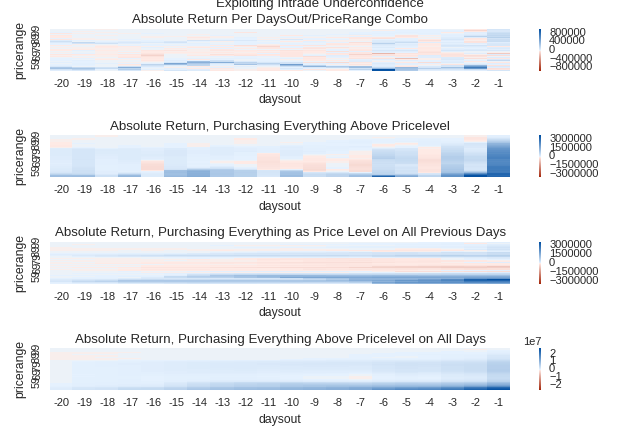

In [29]:
%matplotlib notebook
hmargs = {'yticklabels': 10, 'cmap': cmap}
f, axes = plt.subplots(4,1, sharex=False, sharey=True)
sns.heatmap(strat_heatmap, ax=axes[0], **hmargs)
axes[0].set_title('Absolute Return Per DaysOut/PriceRange Combo')
sns.heatmap(strat_heatmap.cumsum(), ax=axes[1], **hmargs)
axes[1].set_title('Absolute Return, Purchasing Everything Above Pricelevel')
sns.heatmap(strat_heatmap.cumsum(axis=1), ax=axes[2], **hmargs)
axes[2].set_title('Absolute Return, Purchasing Everything as Price Level on All Previous Days')
sns.heatmap(strat_heatmap.cumsum().cumsum(axis=1), ax=axes[3], **hmargs)
axes[3].set_title('Absolute Return, Purchasing Everything Above Pricelevel on All Days')
f.text(0.5, 0.99, 'Exploiting Intrade Underconfidence', ha='center', va='center')
f.tight_layout()

In [27]:
flatledgers = pd.DataFrame()
for lrow in ledgers.itervalues():
    for l in lrow.itervalues():
        flatledgers = pd.concat((flatledgers, l))
flatledgers.sort_index(inplace=True)
flatledgers.rename(columns={0: 'balance'}, inplace=True)

<IPython.core.display.Javascript object>


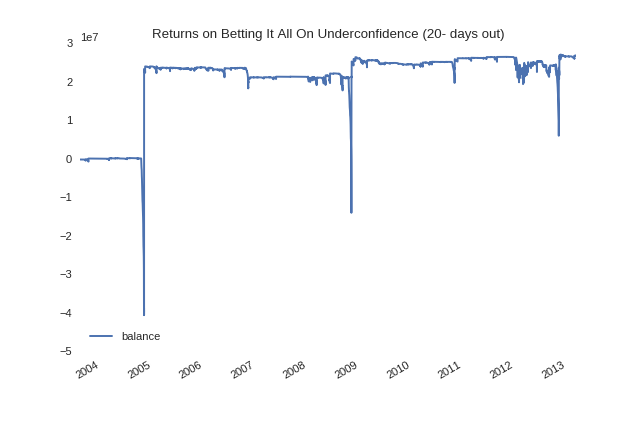

In [75]:
%matplotlib notebook
ax = plt.gca()
flatledgers.cumsum().plot(label='cash on hand', ax=ax)
ax.set_title('Returns on Betting It All On Underconfidence (20- days out)')


In [ ]:

def filter_generator(df, col, vals):
    

In [74]:
for price in xrange(100):
    pfilter = (trades.category=='Politics')
    dfilter = (trades.days == -1)
    cfilter = (trades.trade_price >= price)
    rfilter = (~trades.result.isnull())
    hnptrades = trades[rfilter & (~pfilter) & dfilter & cfilter]
    cost = ((hnptrades.trade_price)*hnptrades.trade_quantity).sum()
    payout = ((hnptrades.result==1)*hnptrades.trade_quantity*100).sum()
    print price, payout - cost

0 -262599.7
1 -246908.8
2 -212591.3
3 -169095.2
4 -136452.4
5 -109513.1
6 -72558.5
7 -71384.5
8 -59619.0
9 -31381.3
10 -15365.9
11 5412.39999997
12 32333.5
13 42419.4
14 18310.3
15 32685.2
16 63121.2999999
17 105711.0
18 135342.8
19 149858.7
20 169025.0
21 113754.0
22 97939.3
23 94163.7
24 95970.9
25 71502.3
26 83377.5
27 84388.7
28 78498.4
29 55199.2
30 34628.1
31 19539.5
32 49804.3
33 55264.5
34 66938.8
35 84453.1
36 87029.1
37 99591.9
38 105231.8
39 123826.1
40 138143.1
41 140332.3
42 139675.6
43 121852.2
44 124336.4
45 148762.2
46 124631.9
47 103906.0
48 130296.3
49 110899.3
50 109927.2
51 106354.9
52 95796.5
53 80171.0
54 173281.5
55 183284.6
56 202279.4
57 210873.0
58 204001.3
59 216385.5
60 221666.5
61 262590.4
62 264749.4
63 274550.4
64 304261.2
65 296464.5
66 348545.1
67 344987.0
68 366988.0
69 375799.6
70 392107.6
71 362506.8
72 371228.2
73 390374.4
74 399213.2
75 402664.7
76 385008.9
77 379477.3
78 379676.0
79 390616.6
80 391704.4
81 340548.0
82 319092.5
83 291452.3
84 26205

In [61]:
payout-cost

-12578753.499999553

In [ ]:
%matplotlib notebook

limits = (99, 95, 90, 85, 80, 70, 60)
f, axes = plt.subplots(len(limits), 2, sharex=True, sharey=True)
for i, lim in enumerate(limits):
    ax1, ax2 = axes[i]
    ax1.set_yscale('symlog')
    ax2.set_yscale('symlog')
    tfilter = (knowntrades.countdown > -pd.datetools.timedelta(days=10)) & (knowntrades.trade_price > lim)
    tnpfilter = tfilter & (knowntrades.category!='Politics')
    ledger, purchases = get_ledger(knowntrades, tfilter)
    ledger.cumsum().plot(ax=ax1)
    outcome = ledger.sum()
    roi = purchases.payout.sum()/-purchases.cost.sum()
    ax1.set_title('Final: %f (%f %%)' % (outcome, roi))
    ledger, purchases = get_ledger(knowntrades, tnpfilter)
    ledger.cumsum().plot(ax=ax2)
    outcome = ledger.sum()
    roi = purchases.payout.sum()/-purchases.cost.sum()
    ax2.set_title('No Politics: Final: %f (%f %%)' % (outcome, roi))
f.tight_layout()

<IPython.core.display.Javascript object>


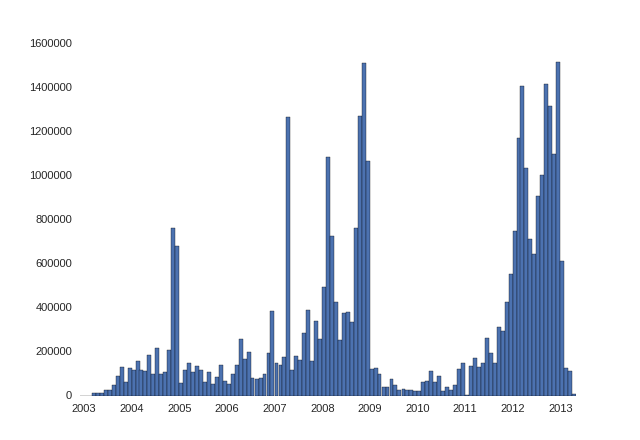

In [414]:
%matplotlib notebook
time_volume = pd.Series(trades.trade_quantity)
times = trades.datetime_utc.copy()
time_volume.index = times
monthly_vol = time_volume.resample('M', how='sum')


ax = plt.subplot(111)
ax.bar(monthly_vol.index, monthly_vol.values, width=30)
ax.xaxis_date()

<IPython.core.display.Javascript object>


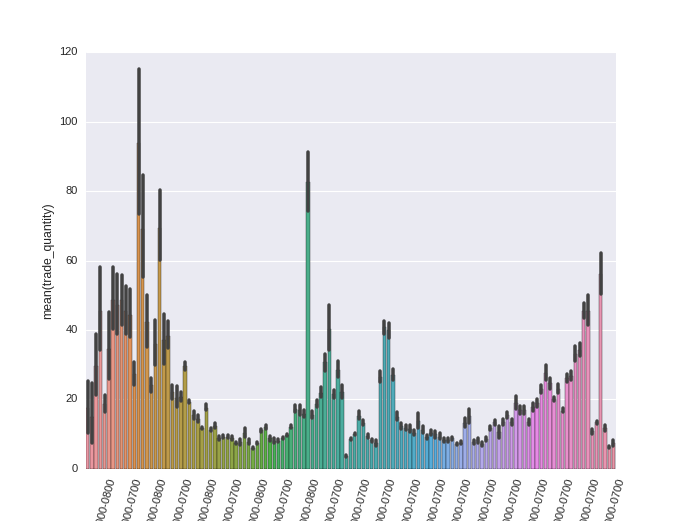

In [91]:
%matplotlib notebook
ax = plt.subplot(111)
sns.barplot(data=trades, x='monthbin', y='trade_quantity', ax=ax)
ax.xaxis_date()
plt.xticks(rotation=75)
for label in ax.xaxis.get_ticklabels():
    label.set_visible(False)
for label in ax.xaxis.get_ticklabels()[::6]:
    label.set_visible(True)